# Date: 04/02/2019, University of Michigan -Ann Arbor
# This is a notebook of how to analyze Micriobiome data
# This pipeline starts with biom file format which outputs from Qiime using the 16S of your samples.
# Using the biom file and the meta data of your sample, I will generate phyloseq object for downstream analysis.


In [2]:
#make sure to install all of these libraries
library('phyloseq')
library(stringr)
library(ggplot2)
library(pheatmap)
library(pheatmap)
library(tidyverse)
library("scales")
library("EMA")
library('plyr') # ldply
library('reshape2')

Warning message:
"package 'phyloseq' was built under R version 3.5.2"Warning message:
"package 'stringr' was built under R version 3.5.2"Warning message:
"package 'ggplot2' was built under R version 3.5.2"

# We will plot the following
# 1- filtration
# 2- Bar plot
# 3- Statistical test
# 4- Rarefraction curve
# 

# Load the data

In [5]:
mypsdata= import_biom("otu_table_mc1_w_tax.biom")
sampleMeta=read.csv("FADHL_MAPPING -Canada1.txt",sep='\t',check.names = F)
row.names(sampleMeta)=sampleMeta$NAME
sampledata = sample_data(data.frame(sampleMeta
                                    ,row.names=rownames(sampleMeta),
                                    stringsAsFactors=FALSE
))
physeq1 = merge_phyloseq(mypsdata, sampledata)
physeq1

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6056 taxa and 51 samples ]
sample_data() Sample Data:       [ 51 samples by 6 sample variables ]
tax_table()   Taxonomy Table:    [ 6056 taxa by 7 taxonomic ranks ]

# We have 51 samples and 6056 Taxa.
# We will filter samples and taxa based on some critieria 

#  First, I will exclude 7 samples that have low reads

In [6]:
physeq1  <- prune_samples(sample_sums(physeq1)>=130, physeq1)
physeq1

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6056 taxa and 44 samples ]
sample_data() Sample Data:       [ 44 samples by 6 sample variables ]
tax_table()   Taxonomy Table:    [ 6056 taxa by 7 taxonomic ranks ]

# Second, I will exclude features that have very few counts based on their abundance levels (minimum counts) across samples (prevalence).

In [8]:
ex3 <- prune_taxa(taxa_sums(physeq1) > 4, physeq1)
filter <- phyloseq::genefilter_sample(ex3, filterfun_sample(function(x) x >= 4), 
                                      A = 0.2*nsamples(ex3))
ps_filtered <- prune_taxa(filter, ex3)
ps_filtered

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 29 taxa and 44 samples ]
sample_data() Sample Data:       [ 44 samples by 6 sample variables ]
tax_table()   Taxonomy Table:    [ 29 taxa by 7 taxonomic ranks ]

In [9]:
#Filter the taxa using a cutoff of 10% for the Inter-quantile range 
gpsf = filter_taxa(ps_filtered, function(x) IQR(x) > 0.1, TRUE)
gpsf   #   28 taxa and 44 samples  

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 28 taxa and 44 samples ]
sample_data() Sample Data:       [ 44 samples by 6 sample variables ]
tax_table()   Taxonomy Table:    [ 28 taxa by 7 taxonomic ranks ]

# These samples have different reads, so we need to normalize them

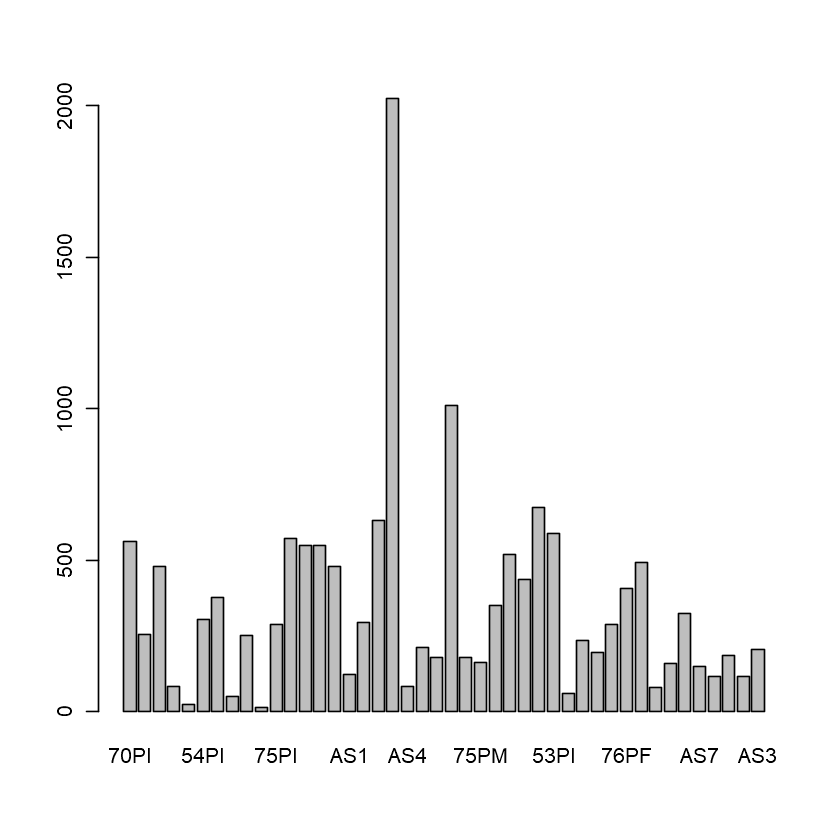

In [13]:
barplot(sample_sums(gpsf))

In [22]:
# We need to exclde sample "66PI" as an outlier
gpsf=subset_samples(gpsf, NAME != "66PI")
gpsf

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 28 taxa and 43 samples ]
sample_data() Sample Data:       [ 43 samples by 6 sample variables ]
tax_table()   Taxonomy Table:    [ 28 taxa by 7 taxonomic ranks ]

In [16]:
# We will use TMM for normalization
physeqNorm=edgeRnorm(gpsf)
otu_table(gpsf)=otu_table(physeqNorm$counts,taxa_are_rows = T)
head(otu_table(gpsf))

,70PI,76PM,77PI,AS2,73PI,54PI,50PI,63PI,61PI,72PI,...,76PF,71PM,56PI,59PI,78PM,AS7,AS6,AS5,AS8,AS3
134726,66,44,66,2,3,12,78,8,22,2,...,56,137,14,12,20,2,2,2,2,2
563163,10,2,6,2,2,9,11,2,7,2,...,9,2,2,2,4,2,2,2,2,2
958496,8,7,3,2,2,2,9,2,8,2,...,4,9,2,4,3,2,2,2,2,2
4425571,9,2,2,2,8,2,2,2,17,4,...,2,2,11,2,24,2,2,2,2,2
588755,29,21,2,2,2,45,2,2,2,2,...,66,2,2,28,34,2,2,2,2,2
302975,7,3,9,2,2,4,7,3,2,2,...,8,15,4,6,4,2,2,2,2,2


# We need to plot bar plot for these taxa in individual samples/sample groups

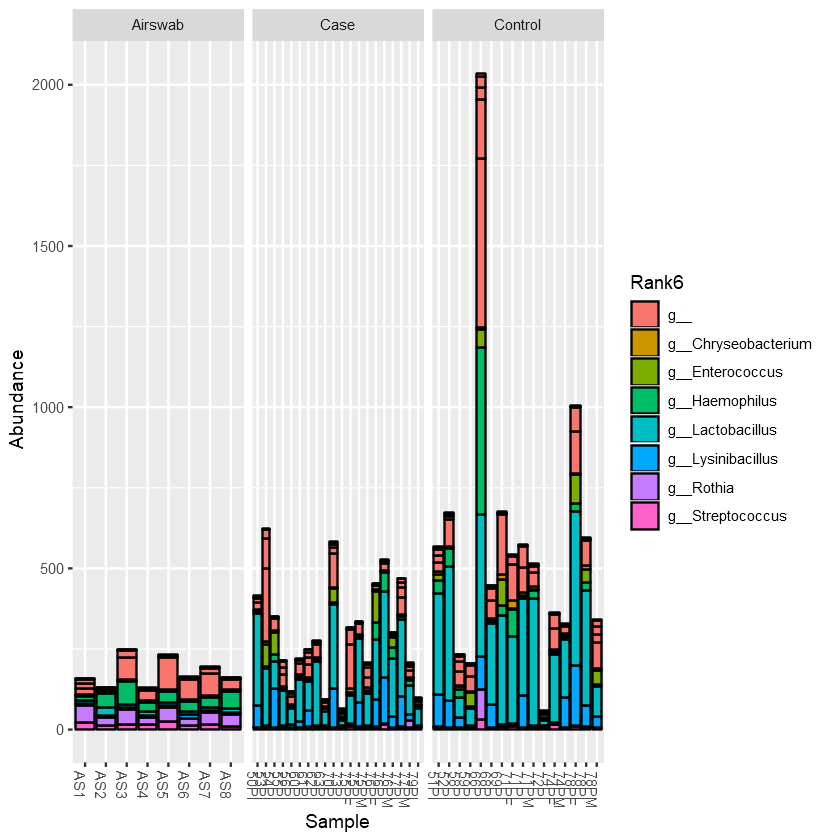

In [19]:
# Plot actual abundance at geneus level 
Rank="Rank6"
ps <- tax_glom(gpsf, Rank)
plot_bar(ps, fill=Rank)+facet_wrap("Status",scales = "free_x")

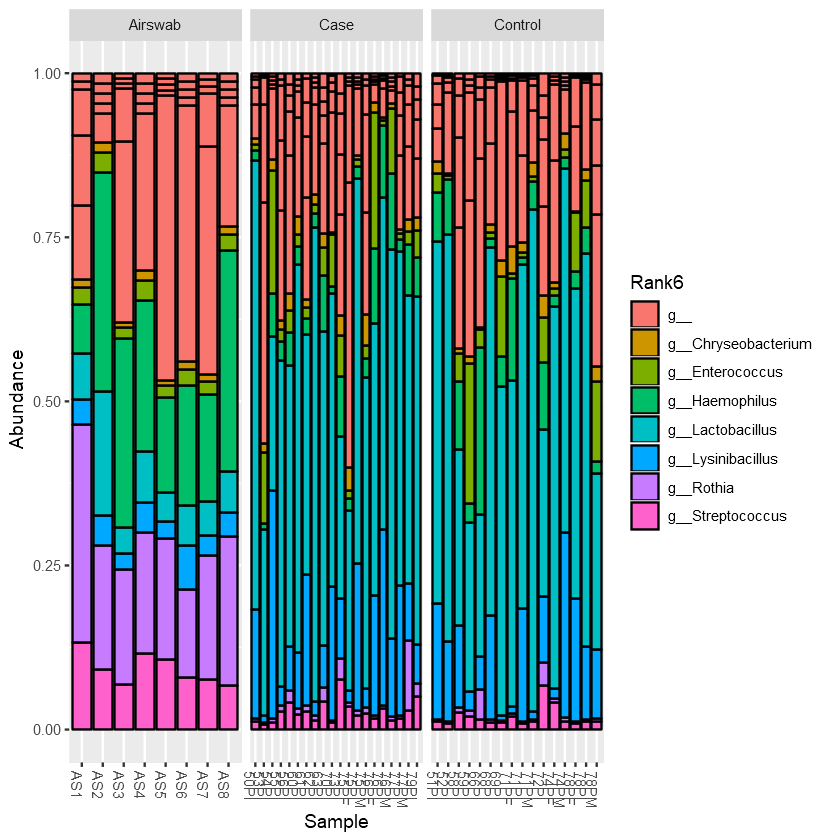

In [20]:
# Plot  relative abundance at genus level 
ps0 <- transform_sample_counts(ps, function(x) x / sum(x))
plot_bar(ps0, fill=Rank)+facet_wrap("Status",scales = "free_x")

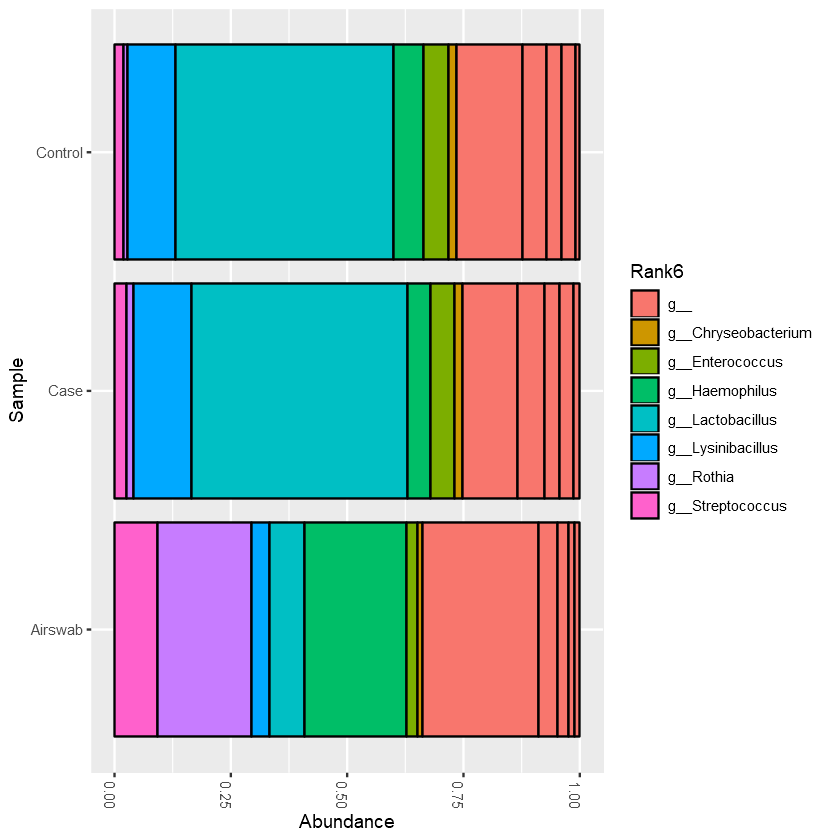

In [21]:
# Plot average relative abundance gropued by case-control-airswab at genus level 
ps1 <- merge_samples(ps0, "Status")
ps2 <- transform_sample_counts(ps1, function(x) x / sum(x))
plot_bar(ps2, fill=Rank)+coord_flip()

#  We need to find which OTU are statistically different among different groups

Launch Wilcoxon test
Calculate pval
Adjusted pval


[1] "typeFDR= FDR-BH"


Warning message in par(font.lab = 2, frame = FALSE):
""frame" is not a graphical parameter"

[1] 15 12

Row.names,Rank1,Rank2,Rank3,Rank4,Rank5,Rank6,Rank7,probeID,Stat,RawpValue,AdjpValue
134726,k__Bacteria,p__Firmicutes,c__Bacilli,o__Lactobacillales,f__Lactobacillaceae,g__Lactobacillus,s__,134726,4.0,1.655075e-07,1.544737e-06
563163,k__Bacteria,p__Firmicutes,c__Bacilli,o__Bacillales,f__Planococcaceae,g__Lysinibacillus,s__boronitolerans,563163,68.0,2.353775e-02,4.393713e-02
958496,k__Bacteria,p__Firmicutes,c__Bacilli,o__Lactobacillales,f__Lactobacillaceae,g__Lactobacillus,s__,958496,32.0,2.951827e-04,1.180731e-03
302975,k__Bacteria,p__Firmicutes,c__Bacilli,o__Lactobacillales,f__Lactobacillaceae,g__Lactobacillus,s__,302975,16.0,1.096487e-05,5.116941e-05
866280,k__Bacteria,p__Actinobacteria,c__Actinobacteria,o__Actinomycetales,f__Micrococcaceae,g__Rothia,s__mucilaginosa,866280,279.5,1.379229e-08,3.861842e-07
3778553,k__Bacteria,p__Bacteroidetes,c__Flavobacteriia,o__Flavobacteriales,f__[Weeksellaceae],g__Chryseobacterium,s__,3778553,48.0,2.893099e-03,7.364252e-03


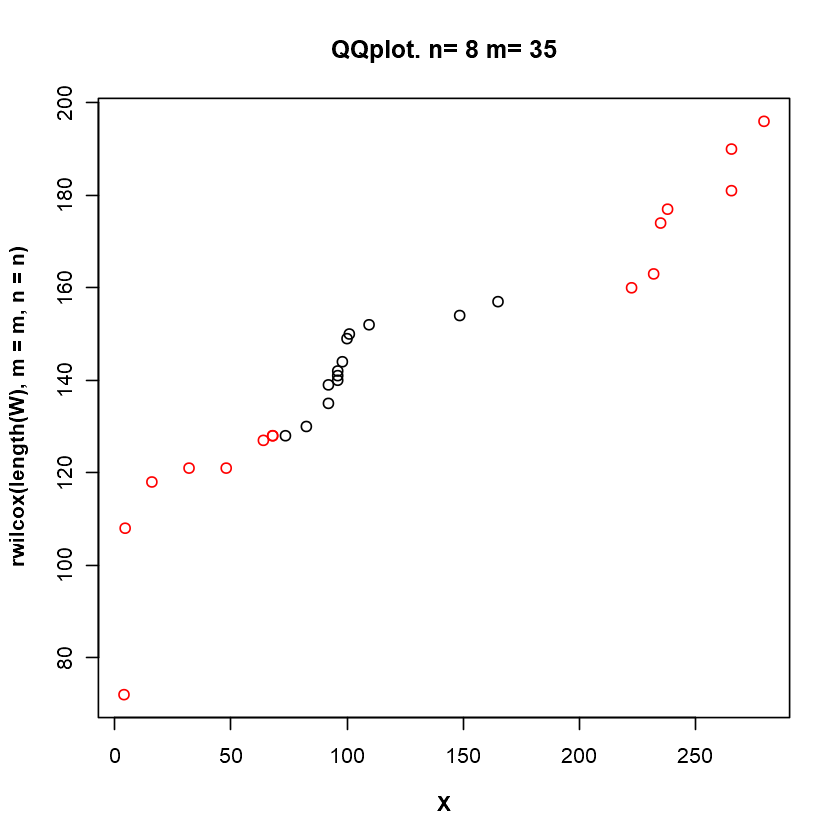

In [33]:
## 15 OTU are statistically different between placenta and Airswab
library("EMA")
myotu_table<-as(otu_table(gpsf), "matrix")
mymeta_data <- as(sample_data(gpsf), "data.frame")
myclass =mymeta_data$Type #Class of the pairwise comparison ("Control VS treatment")
myclass.num <- ifelse(myclass=="Airswab", 0,1) #Define a class i.e Control 
myWilcox_test=EMA::runWilcox(myotu_table, myclass.num, typeFDR = "FDR-BH", q = 0.05, plot = TRUE)

#add the tax_table
row.names(myWilcox_test) = myWilcox_test$probeID
wilcox_testFDR =  merge(as.data.frame(tax_table(gpsf)), as.data.frame(myWilcox_test), by='row.names', sort=F)

wilcox_testFDR %>% filter(AdjpValue<=0.05) %>% dim
wilcox_testFDR %>% filter(AdjpValue<=0.05) %>% head

Launch Wilcoxon test
Calculate pval
Adjusted pval


[1] "typeFDR= FDR-BH"


Warning message in par(font.lab = 2, frame = FALSE):
""frame" is not a graphical parameter"

[1] 28 12

[1]  0 12

Row.names,Rank1,Rank2,Rank3,Rank4,Rank5,Rank6,Rank7,probeID,Stat,RawpValue,AdjpValue


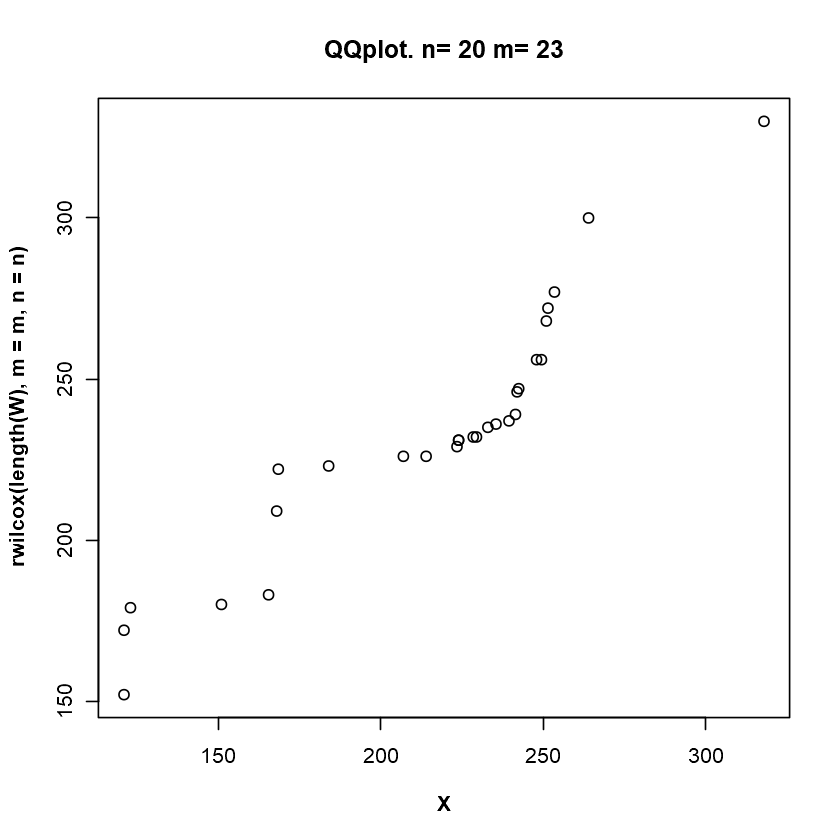

In [32]:
# 0 OTU are statistically different between case and control
library("EMA")
myotu_table<-as(otu_table(gpsf), "matrix")
mymeta_data <- as(sample_data(gpsf), "data.frame")
myclass =mymeta_data$Status #Class of the pairwise comparison ("Control VS treatment")
myclass.num <- ifelse(myclass=="Case", 0,1) #Define a class i.e Control 
myWilcox_test=EMA::runWilcox(myotu_table, myclass.num, typeFDR = "FDR-BH", q = 0.05, plot = TRUE)
#add the tax_table
row.names(myWilcox_test) = myWilcox_test$probeID
wilcox_testFDR =  merge(as.data.frame(tax_table(gpsf)), as.data.frame(myWilcox_test), by='row.names', sort=F)
dim(wilcox_testFDR )
wilcox_testFDR %>% filter(AdjpValue<=0.05) %>% dim
wilcox_testFDR %>% filter(AdjpValue<=0.05) %>% head

# We need to plot the rarefaction curve of your samples which shows if the sequnce depth of your samples was sufficient 

In [51]:
mypsdata= import_biom("otu_table_mc1_w_tax.biom")
colnames(mypsdata@otu_table)[!str_detect(colnames(mypsdata@otu_table),'A')]=paste0('X',
                                                colnames(mypsdata@otu_table)[!str_detect(colnames(mypsdata@otu_table),'A')])

In [52]:
sampleMeta=read.csv("FADHL_MAPPING -Canada -physeq.txt",sep='\t',check.names = F)
row.names(sampleMeta)=sampleMeta$NAME

sampledata = sample_data(data.frame(sampleMeta
  ,row.names=rownames(sampleMeta),
  stringsAsFactors=FALSE
))
#colnames(physeq1@otu_table)[!str_detect(colnames(physeq1@otu_table),'A')]=paste0('X',colnames(physeq1@otu_table)[!str_detect(colnames(physeq1@otu_table),'A')])

physeq1 = merge_phyloseq(mypsdata, sampledata)
#Taxa filtration
#Features having low count and variance can be removed during the filtration step. Features having very few counts are filtered based
#on their abundance levels (minimum counts) across samples (prevalence).

# filter Taxa with positive sum across samples
ex3 <- prune_taxa(taxa_sums(physeq1) > 4, physeq1)
ex3

# filter taxa based on
filter <- phyloseq::genefilter_sample(ex3, filterfun_sample(function(x) x >= 4), 
                                      A = 0.2*nsamples(ex3))
ps_filtered <- prune_taxa(filter, ex3)
ps_filtered


#Filter the taxa using a cutoff of 10% for the Inter-quantile range 

#gpsf = filter_taxa(ps_filtered, function(x) sd(x)/mean(x) > 0.1, TRUE)
gpsf = filter_taxa(ps_filtered, function(x) IQR(x) > 0.1, TRUE)
gpsf   #   28 taxa and 44 samples   

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 786 taxa and 51 samples ]
sample_data() Sample Data:       [ 51 samples by 6 sample variables ]
tax_table()   Taxonomy Table:    [ 786 taxa by 7 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 23 taxa and 51 samples ]
sample_data() Sample Data:       [ 51 samples by 6 sample variables ]
tax_table()   Taxonomy Table:    [ 23 taxa by 7 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 22 taxa and 51 samples ]
sample_data() Sample Data:       [ 51 samples by 6 sample variables ]
tax_table()   Taxonomy Table:    [ 22 taxa by 7 taxonomic ranks ]

In [53]:
rarefaction_curve_data1 <- calculate_rarefaction_curves(gpsf, c('Observed', 'Shannon'), rep(c( 1:100 ), each = 10))

Loading required package: plyr
------------------------------------------------------------------------------
You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)
------------------------------------------------------------------------------

Attaching package: 'plyr'

The following objects are masked from 'package:dplyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from 'package:purrr':

    compact

Warning message in sqrt(sum(Deriv.Ch1 %*% t(Deriv.Ch1) * (diag(a) - a %*% t(a)/S.ACE))):
"NaNs produced"Warning message in sqrt(sum(Deriv.Ch1 %*% t(Deriv.Ch1) * (diag(a) - a %*% t(a)/S.ACE))):
"NaNs produced"Warning message in sqrt(sum(Deriv.Ch1 %*% t(Deriv.Ch1) * (diag(a) - a %*% t(a)/S.ACE))):
"NaNs produced"Warning message in sqrt(sum(Deriv.Ch1 %*% t(Deriv.Ch1) * (diag(a) - a %*% t(a)/S.AC

In [54]:
rarefaction_curve_data_summary <- ddply(rarefaction_curve_data1, c('Depth', 'Sample', 'Measure'), summarise, Alpha_diversity_mean = mean(Alpha_diversity),
                                        Alpha_diversity_sd = sd(Alpha_diversity))

In [55]:
rarefaction_curve_data_summary_verbose <- merge(rarefaction_curve_data_summary, sampleMeta, by.x = 'Sample', by.y = 'row.names')

In [59]:
detach(package:plyr)
rarefaction_curve_data_summary_verbose_case_control=
  rarefaction_curve_data_summary_verbose %>% group_by(Status,Depth,Measure) %>% summarise(X=mean(Alpha_diversity_mean),
                                  Y=mean(Alpha_diversity_sd))
tail(rarefaction_curve_data_summary_verbose_case_control)

Status,Depth,Measure,X,Y
Control,98,Observed,11.133333,0.93258591
Control,98,Shannon,1.872327,0.07887184
Control,99,Observed,10.966667,1.01823485
Control,99,Shannon,1.870422,0.09675221
Control,100,Observed,10.913333,0.98748765
Control,100,Shannon,1.850901,0.09781294


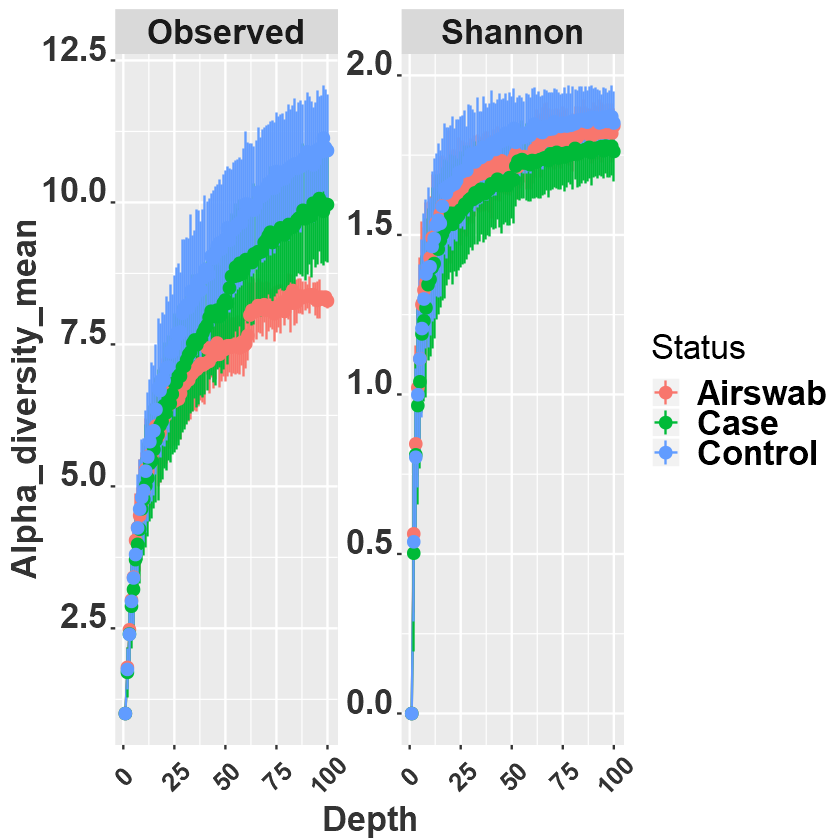

In [60]:
ggplot(
  data = rarefaction_curve_data_summary_verbose_case_control,
  mapping = aes(
    x = Depth,
    y = X,
    ymin = X - Y,
    ymax = X + Y,
    colour = Status,
    group = Status
  )
) + geom_line(
) + geom_pointrange(
) + facet_wrap(
  facets = ~ Measure,
  scales = 'free_y'
)+ylab("Alpha_diversity_mean")+
  theme(axis.text.x = element_text(color = "grey20", size = 15, angle = 45, hjust = .5, vjust = .5, face = "bold"),
        axis.text.y = element_text(color = "grey20", size = 20, angle = 0, hjust = 1, vjust = 0, face = "bold"),  
        axis.title.x = element_text(color = "grey20", size = 20, angle = 0, hjust = .5, vjust = 0, face = "bold"),
        axis.title.y = element_text(color = "grey20", size = 20, angle = 90, hjust = .5, vjust = .5, face = "bold"),
        legend.title=element_text(size=20),
        strip.text = element_text(size = 20,face="bold"),legend.text=element_text(size=20,face="bold"))


In [14]:
edgeRnorm = function(physeq) {
  require("edgeR")
  require("phyloseq")
  # physeq = simlist0[[1]] physeq = simlist0[[117]] Enforce orientation.
  if (!taxa_are_rows(physeq)) {
    physeq <- t(physeq)
  }
  x = as(otu_table(physeq), "matrix")
  # Add one to protect against overflow, log(0) issues.
  x = x + 1
  # Now turn into a DGEList
  y = DGEList(counts = x)  #, group = get_variable(physeq, "Status"))  #, remove.zeros=TRUE)
  # Perform edgeR-encoded normalization, using the following method
  #z = calcNormFactors(y, method = "RLE")
   z = calcNormFactors(y, method='TMM') #A check that we didn't divide by zero
  # inside `calcNormFactors`
  if (!all(is.finite(z$samples$norm.factors))) {
    stop("Something wrong with edgeR::calcNormFactors on this data, non-finite $norm.factors")
  }
  # Estimate dispersions
  z1 = estimateCommonDisp(z)
  z2 = estimateTagwiseDisp(z1)
  return(z2)
}

In [35]:
calculate_rarefaction_curves <- function(psdata, measures, depths) {
  require('plyr') # ldply
  require('reshape2') # melt
  
  estimate_rarified_richness <- function(psdata, measures, depth) {
    if(max(sample_sums(psdata)) < depth) return()
    psdata <- prune_samples(sample_sums(psdata) >= depth, psdata)
    
    rarified_psdata <- rarefy_even_depth(psdata, depth, verbose = FALSE)
    
    alpha_diversity <- estimate_richness(rarified_psdata, measures = measures)
    
    # as.matrix forces the use of melt.array, which includes the Sample names (rownames)
    molten_alpha_diversity <- melt(as.matrix(alpha_diversity), varnames = c('Sample', 'Measure'), value.name = 'Alpha_diversity')
    
    molten_alpha_diversity
  }
  
  names(depths) <- depths # this enables automatic addition of the Depth to the output by ldply
  rarefaction_curve_data <- ldply(depths, estimate_rarified_richness, psdata = psdata, measures = measures, .id = 'Depth', .progress = ifelse(interactive(), 'text', 'none'))
  
  # convert Depth from factor to numeric
  rarefaction_curve_data$Depth <- as.numeric(levels(rarefaction_curve_data$Depth))[rarefaction_curve_data$Depth]
  
  rarefaction_curve_data
}